In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix,classification_report

import glob
from tqdm import tqdm

In [ ]:
%%time
DF = pd.read_csv('/content/drive/MyDrive/default_model/default model/data/df13.csv')
DF.head(2)

CPU times: user 16.4 s, sys: 4.03 s, total: 20.5 s
Wall time: 31 s


,Unnamed: 0,lead_id,application_id,borrower_name,proposed_payment_date,actual_payment_date,disbursal_amount,emi_no,dpd,principle_amount,interest_amount,balance,Gender,gender_id,DateOfBirth,cibilScore,has_coborrower,institutes_name,course_name,course_cost,requested_loan_amount,loan_type,bre_status,current_status,current_employment_duration,fk_applicant_type_id,profession,marital_status,annual_income,has_active_loan,current_address_city,current_address_state,current_address_pin,permanent_address_city,permanent_address_state,permanent_address_pin,final_disbursal_amount,rate_of_interest,tenure,is_moratorium,product_type,rate,loan_initiated,no_emi_paid,OGL,protection_type,course_id,related_industry,course_duration,course_category,institute_type,industry_name,nach_provider,lender_name,status_name,status,age
0,0,6.0,A180119006,Vijay Uttekar,2019-01-15,2019-01-05,60125.0,12,-10.0,4651.0,349.0,9644.0,NaN,-,NaN,NaN,NaN,Vivo Healthcare Pvt Ltd,Radiology Technician,65000.0,65000.0,NaN,NaN,NaN,4.0,2.0,Salaried,Married,200000.0,0.0,7.0,2.0,411032.0,7.0,2.0,411032.0,65000.0,7.69,14.0,NaN,3.0,7.5,Running,14.0,NaN,NaN,9.0,18.0,12.0,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,1,NaN
1,1,6.0,A180119006,Vijay Uttekar,2019-02-15,2019-02-05,60125.0,13,-10.0,4764.0,235.0,4880.0,NaN,-,NaN,NaN,NaN,Vivo Healthcare Pvt Ltd,Radiology Technician,65000.0,65000.0,NaN,NaN,NaN,4.0,2.0,Salaried,Married,200000.0,0.0,7.0,2.0,411032.0,7.0,2.0,411032.0,65000.0,7.69,14.0,NaN,3.0,7.5,Running,14.0,NaN,NaN,9.0,18.0,12.0,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,1,NaN


In [ ]:
DF['actual_payment_date'] = pd.to_datetime(DF['actual_payment_date'])
DF['proposed_payment_date'] = pd.to_datetime(DF['proposed_payment_date'])

In [ ]:
DF['DPD'] =  (DF['actual_payment_date'] - DF['proposed_payment_date']).dt.days
DF.loc[DF['status'] == 0,'DPD'] = (datetime.datetime.today() - DF['proposed_payment_date']).dt.days

In [ ]:
DF['status_name'].value_counts()

Agreement Pending    25
Name: status_name, dtype: int64

In [ ]:
len(DF['application_id'].unique())

173196

In [ ]:
filt_col = ['lead_id', 'application_id', 'borrower_name',
       'disbursal_amount', 'gender_id', 'cibilScore', 'has_coborrower', 'institutes_name',
       'course_cost', 'requested_loan_amount', 'loan_type',
       'bre_status', 'current_employment_duration','profession', 'marital_status', 'annual_income',
       'current_address_pin','permanent_address_pin',
       'final_disbursal_amount', 'rate_of_interest', 'tenure', 'is_moratorium',
       'product_type', 'rate', 'OGL','protection_type', 'related_industry', 'course_duration',
       'course_category', 'institute_type', 'industry_name', 'nach_provider',
       'lender_name', 'age','DPD']

dup_filt_col = ['lead_id', 'application_id', 'borrower_name',
       'disbursal_amount', 'gender_id', 'cibilScore', 'has_coborrower', 'institutes_name',
       'course_cost', 'requested_loan_amount', 'loan_type',
       'bre_status', 'current_employment_duration','profession', 'marital_status', 'annual_income',
       'current_address_pin','permanent_address_pin',
       'final_disbursal_amount', 'rate_of_interest', 'tenure', 'is_moratorium',
       'product_type', 'rate', 'OGL','protection_type', 'related_industry', 'course_duration',
       'course_category', 'institute_type', 'industry_name', 'nach_provider',
       'lender_name', 'age']

In [ ]:
DF_app_gby = DF.groupby('application_id')

In [ ]:
DF['DPD'].isna().sum()

19492

In [ ]:
df_inc = pd.DataFrame()
for app_id,df_app_id in tqdm(DF_app_gby):

    ind_df_app_id = df_app_id[filt_col]

    ind_df_app_id['avg_dpd'] = ind_df_app_id['DPD'].mean()
    ind_df_app_id['max_dpd'] = ind_df_app_id['DPD'].max()
    ind_df_app_id['min_dpd'] = ind_df_app_id['DPD'].min()
    ind_df_app_id['x_dpd_per'] = round(((ind_df_app_id[(ind_df_app_id['DPD'] >= 0)&(ind_df_app_id['DPD'] <= 30)].shape[0])/(ind_df_app_id.shape[0]))*100,2)
    ind_df_app_id['30+_dpd_per'] = round(((ind_df_app_id[(ind_df_app_id['DPD'] > 30)&(ind_df_app_id['DPD'] <= 90)].shape[0])/(ind_df_app_id.shape[0]))*100,2)
    ind_df_app_id['90+_dpd_per'] = round(((ind_df_app_id[ind_df_app_id['DPD'] > 90].shape[0])/(ind_df_app_id.shape[0]))*100,2)
    ind_df_app_id.drop_duplicates(dup_filt_col,keep='last',inplace=True)

    # if inc % 1000 == 0 :

    #   df_org = pd.concat(ind_df_app_id_ls, axis=0, ignore_index=True)
    #   ind_df_app_id_ls = []

    #   df_org.to_csv(f'/content/drive/MyDrive/default_model/default model/data/backup/{inc}.csv')


    df_inc = pd.concat([df_inc,ind_df_app_id],axis=0,ignore_index=True)
    # display(ind_df_app_id)

    # break

100%|██████████| 173195/173195 [56:32<00:00, 51.06it/s]


In [ ]:
df_inc

,lead_id,application_id,borrower_name,disbursal_amount,gender_id,cibilScore,has_coborrower,institutes_name,course_cost,requested_loan_amount,loan_type,bre_status,current_employment_duration,profession,marital_status,annual_income,current_address_pin,permanent_address_pin,final_disbursal_amount,rate_of_interest,tenure,is_moratorium,product_type,rate,OGL,protection_type,related_industry,course_duration,course_category,institute_type,industry_name,nach_provider,lender_name,age,DPD,avg_dpd,max_dpd,min_dpd,x_dpd_per,30+_dpd_per,90+_dpd_per
0,2.0,A180118002,Aditya Satyamoorthy,450000.0,-,NaN,NaN,Aegis,500000.0,450000.0,NaN,NaN,NaN,Student,Single,NaN,401107.0,401107.0,450000.0,16.05,36.0,NaN,1.0,NaN,NaN,NaN,2.0,12.0,White Collar Personnal,Vocational,ANALYTICS,physical,Eduvanz Financing Pvt. Ltd.,NaN,0.0,0.200000,5.0,0.0,100.00,0.0,0.0
1,8.0,A180119005,Sashank Chittipeddi,100000.0,-,NaN,NaN,QuantInsti Quantitative Learning Pvt Ltd,284368.0,100000.0,NaN,NaN,2.0,Salaried,Single,1000000.0,560102.0,560102.0,100000.0,6.00,12.0,NaN,3.0,9.65000,NaN,NaN,6.0,6.0,White Collar Personnal,Vocational,BFSI,NaN,Eduvanz Financing Pvt. Ltd.,NaN,2.0,2.000000,2.0,2.0,100.00,0.0,0.0
2,6.0,A180119006,Vijay Uttekar,60125.0,-,NaN,NaN,Vivo Healthcare Pvt Ltd,65000.0,65000.0,NaN,NaN,4.0,Salaried,Married,200000.0,411032.0,411032.0,65000.0,7.69,14.0,NaN,3.0,7.50000,NaN,NaN,18.0,12.0,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,-10.0,-10.000000,-10.0,-10.0,0.00,0.0,0.0
3,18.0,A180120008,Anik C,200000.0,-,NaN,NaN,Times Pro,425000.0,200000.0,NaN,NaN,1.0,Salaried,Single,280000.0,562123.0,680687.0,200000.0,15.40,36.0,NaN,1.0,NaN,NaN,NaN,20.0,1.0,White Collar Personnal,Vocational,IT & ITES,NaN,Eduvanz Financing Pvt. Ltd.,NaN,268.0,174.560000,421.0,2.0,20.00,16.0,64.0
4,21.0,A180122001,Vaibhav Kasar,391000.0,-,NaN,NaN,Seed Infotech,445000.0,391000.0,NaN,NaN,2.0,Salaried,Married,320000.0,411045.0,400078.0,391000.0,13.50,36.0,NaN,1.0,NaN,NaN,NaN,20.0,1.0,White Collar Personnal,Vocational,IT & ITES,NaN,Eduvanz Financing Pvt. Ltd.,NaN,978.0,1344.320000,1709.0,978.0,0.00,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173190,1365209.0,A230909559,S Reddy,244564.0,Male,00801,0.0,Scaler Academy,434000.0,294000.0,Certification Loan,NaN,4.0,Salaried,Single,1503024.0,518002.0,518002.0,294000.0,0.00,24.0,2.0,2.0,18.34121,No,NO PROTECTION,11.0,9.0,White Collar Personnal,Vocational,EDUCATION & TRAINING,razorpay,ABFL,28.0,-726.0,-375.541667,-25.0,-726.0,0.00,0.0,0.0
173191,1365324.0,A230910080,Sunayan Sarkar,130442.0,Male,00809,0.0,"Hey Coach Education Private Limited,",488000.0,132000.0,Certification Loan,NaN,3.0,Salaried,Single,1990440.0,560067.0,560067.0,132000.0,10.78,24.0,2.0,3.0,20.73696,No,NO PROTECTION,13.0,24.0,White Collar Personnal,Vocational,ENGINEERING SERVICES,razorpay,ABFL,39.0,-726.0,-375.541667,-25.0,-726.0,0.00,0.0,0.0
173192,1365369.0,A230910126,Minumula Reddy,294000.0,Male,00750,0.0,Scaler Academy,434000.0,294000.0,Certification Loan,NaN,3.0,Salaried,Single,654396.0,506005.0,506005.0,294000.0,9.50,60.0,2.0,1.0,16.50104,No,NO PROTECTION,11.0,9.0,White Collar Personnal,Vocational,EDUCATION & TRAINING,razorpay,ABFL,23.0,-1822.0,-923.283333,-25.0,-1822.0,0.00,0.0,0.0
173193,1365451.0,A230910211,Debopriya Lahiri,38932.0,Female,00772,0.0,Prepladder Pvt Ltd,120000.0,42990.0,Certification Loan,NaN,4.0,Salaried,Single,450000.0,201310.0,201310.0,42990.0,0.00,12.0,2.0,2.0,22.30945,No,PRINCIPAL PROTECTION TILL LOAN TENURE,11.0,12.0,White Collar Personnal,Vocational,EDUCATION & TRAINING,razorpay,ABFL,21.0,-330.0,-162.750000,0.0,-330.0,8.33,0.0,0.0


In [ ]:
# df_inc.to_csv('/content/drive/MyDrive/default_model/default model/data/df_credit_risk_uniq_applicants.csv')

In [ ]:
df_inc = pd.read_csv('/content/drive/MyDrive/default_model/default model/data/df_credit_risk_uniq_applicants.csv')

In [ ]:
display(df_inc.head(2))
df_inc.shape

,Unnamed: 0,lead_id,application_id,borrower_name,disbursal_amount,gender_id,cibilScore,has_coborrower,institutes_name,course_cost,requested_loan_amount,loan_type,bre_status,current_employment_duration,profession,marital_status,annual_income,current_address_pin,permanent_address_pin,final_disbursal_amount,rate_of_interest,tenure,is_moratorium,product_type,rate,OGL,protection_type,related_industry,course_duration,course_category,institute_type,industry_name,nach_provider,lender_name,age,DPD,avg_dpd,max_dpd,min_dpd,x_dpd_per,30+_dpd_per,90+_dpd_per
0,0,2.0,A180118002,Aditya Satyamoorthy,450000.0,-,NaN,NaN,Aegis,500000.0,450000.0,NaN,NaN,NaN,Student,Single,NaN,401107.0,401107.0,450000.0,16.05,36.0,NaN,1.0,NaN,NaN,NaN,2.0,12.0,White Collar Personnal,Vocational,ANALYTICS,physical,Eduvanz Financing Pvt. Ltd.,NaN,0.0,0.2,5.0,0.0,100.0,0.0,0.0
1,1,8.0,A180119005,Sashank Chittipeddi,100000.0,-,NaN,NaN,QuantInsti Quantitative Learning Pvt Ltd,284368.0,100000.0,NaN,NaN,2.0,Salaried,Single,1000000.0,560102.0,560102.0,100000.0,6.00,12.0,NaN,3.0,9.65,NaN,NaN,6.0,6.0,White Collar Personnal,Vocational,BFSI,NaN,Eduvanz Financing Pvt. Ltd.,NaN,2.0,2.0,2.0,2.0,100.0,0.0,0.0


(173195, 42)

In [ ]:
df_inc.columns

Index(['Unnamed: 0', 'lead_id', 'application_id', 'borrower_name',
       'disbursal_amount', 'gender_id', 'cibilScore', 'has_coborrower',
       'institutes_name', 'course_cost', 'requested_loan_amount', 'loan_type',
       'bre_status', 'current_employment_duration', 'profession',
       'marital_status', 'annual_income', 'current_address_pin',
       'permanent_address_pin', 'final_disbursal_amount', 'rate_of_interest',
       'tenure', 'is_moratorium', 'product_type', 'rate', 'OGL',
       'protection_type', 'related_industry', 'course_duration',
       'course_category', 'institute_type', 'industry_name', 'nach_provider',
       'lender_name', 'age', 'DPD', 'avg_dpd', 'max_dpd', 'min_dpd',
       'x_dpd_per', '30+_dpd_per', '90+_dpd_per'],
      dtype='object')

In [ ]:
df_inc[['DPD', 'avg_dpd', 'max_dpd','min_dpd', 'x_dpd_per', '30+_dpd_per', '90+_dpd_per']].describe()

,DPD,avg_dpd,max_dpd,min_dpd,x_dpd_per,30+_dpd_per,90+_dpd_per
count,172559.000000,173195.000000,173195.000000,173195.000000,173195.000000,173195.000000,173195.000000
mean,-112.313812,-18.817602,79.305453,-173.028794,57.672378,2.713656,7.894394
std,382.343795,207.392674,215.720792,750.600835,36.508288,8.967168,22.081931
min,-19301.000000,-3641.000000,-391.000000,-19331.000000,0.000000,0.000000,0.000000
25%,-208.000000,-47.777778,0.000000,-208.000000,22.220000,0.000000,0.000000
50%,0.000000,-0.125000,1.000000,-8.000000,60.000000,0.000000,0.000000
75%,0.000000,0.750000,17.000000,0.000000,100.000000,0.000000,0.000000
max,1709.000000,1709.000000,1709.000000,1709.000000,100.000000,100.000000,100.000000


In [ ]:
df_inc.shape

(173195, 42)

In [ ]:
df_inc.columns

Index(['Unnamed: 0', 'lead_id', 'application_id', 'borrower_name',
       'disbursal_amount', 'gender_id', 'cibilScore', 'has_coborrower',
       'institutes_name', 'course_cost', 'requested_loan_amount', 'loan_type',
       'bre_status', 'current_employment_duration', 'profession',
       'marital_status', 'annual_income', 'current_address_pin',
       'permanent_address_pin', 'final_disbursal_amount', 'rate_of_interest',
       'tenure', 'is_moratorium', 'product_type', 'rate', 'OGL',
       'protection_type', 'related_industry', 'course_duration',
       'course_category', 'institute_type', 'industry_name', 'nach_provider',
       'lender_name', 'age', 'DPD', 'avg_dpd', 'max_dpd', 'min_dpd',
       'x_dpd_per', '30+_dpd_per', '90+_dpd_per'],
      dtype='object')

In [ ]:
df_inc[df_inc['90+_dpd_per'] > 25][['DPD', 'avg_dpd', 'max_dpd','min_dpd', 'x_dpd_per', '30+_dpd_per', '90+_dpd_per']].describe()

,DPD,avg_dpd,max_dpd,min_dpd,x_dpd_per,30+_dpd_per,90+_dpd_per
count,18791.000000,18981.000000,18981.000000,18981.000000,18981.000000,18981.000000,18981.000000
mean,263.380874,327.668760,588.771456,-0.341710,15.525978,6.961544,66.587807
std,376.986872,277.938143,302.688654,391.906198,16.520232,9.166174,22.218320
min,-1339.000000,-1299.916667,92.000000,-18663.000000,0.000000,0.000000,25.810000
25%,5.000000,121.181818,370.000000,-25.000000,0.000000,0.000000,50.000000
50%,179.000000,246.000000,523.000000,-1.000000,9.090000,4.760000,66.670000
75%,554.000000,445.047619,766.000000,0.000000,25.000000,10.530000,86.360000
max,1709.000000,1709.000000,1709.000000,1709.000000,73.330000,68.180000,100.000000


In [ ]:
df_inc[(df_inc['90+_dpd_per'] > 0)&(df_inc['90+_dpd_per'] <= 25)][['DPD', 'avg_dpd', 'max_dpd','min_dpd', 'x_dpd_per', '30+_dpd_per', '90+_dpd_per']].describe()

,DPD,avg_dpd,max_dpd,min_dpd,x_dpd_per,30+_dpd_per,90+_dpd_per
count,7486.000000,7665.000000,7665.000000,7665.000000,7665.000000,7665.000000,7665.000000
mean,-128.912103,-40.969048,227.461187,-278.045401,33.107705,17.170397,13.485496
std,580.247554,166.589734,226.163250,816.566534,24.660333,16.583803,6.473226
min,-19301.000000,-2046.222222,91.000000,-19301.000000,0.000000,0.000000,1.490000
25%,-391.000000,-82.958333,97.000000,-391.000000,12.500000,8.330000,8.330000
50%,-148.000000,5.208333,128.000000,-148.000000,27.270000,10.530000,13.640000
75%,101.000000,38.846154,217.000000,-2.000000,50.000000,22.730000,18.180000
max,1589.000000,357.700000,1589.000000,59.000000,97.730000,91.670000,25.000000


In [ ]:
df_inc['category'] = 'Moderate'
df_inc.loc[((df_inc['90+_dpd_per'] > 25))|((df_inc['90+_dpd_per'] > 0)&(df_inc['90+_dpd_per'] <= 25)&(df_inc['30+_dpd_per'] > 33)),'category'] = 'Bad'
df_inc.loc[(df_inc['x_dpd_per'] >= 80)&(df_inc['90+_dpd_per'] <= 0),'category'] = 'Good'

In [ ]:
df_inc['category'].value_counts(normalize=True)

Moderate    0.482422
Good        0.400647
Bad         0.116932
Name: category, dtype: float64

In [ ]:
df_inc.head(2)

,Unnamed: 0,lead_id,application_id,borrower_name,disbursal_amount,gender_id,cibilScore,has_coborrower,institutes_name,course_cost,requested_loan_amount,loan_type,bre_status,current_employment_duration,profession,marital_status,annual_income,current_address_pin,permanent_address_pin,final_disbursal_amount,rate_of_interest,tenure,is_moratorium,product_type,rate,OGL,protection_type,related_industry,course_duration,course_category,institute_type,industry_name,nach_provider,lender_name,age,DPD,avg_dpd,max_dpd,min_dpd,x_dpd_per,30+_dpd_per,90+_dpd_per,category
0,0,2.0,A180118002,Aditya Satyamoorthy,450000.0,-,NaN,NaN,Aegis,500000.0,450000.0,NaN,NaN,NaN,Student,Single,NaN,401107.0,401107.0,450000.0,16.05,36.0,NaN,1.0,NaN,NaN,NaN,2.0,12.0,White Collar Personnal,Vocational,ANALYTICS,physical,Eduvanz Financing Pvt. Ltd.,NaN,0.0,0.2,5.0,0.0,100.0,0.0,0.0,Good
1,1,8.0,A180119005,Sashank Chittipeddi,100000.0,-,NaN,NaN,QuantInsti Quantitative Learning Pvt Ltd,284368.0,100000.0,NaN,NaN,2.0,Salaried,Single,1000000.0,560102.0,560102.0,100000.0,6.00,12.0,NaN,3.0,9.65,NaN,NaN,6.0,6.0,White Collar Personnal,Vocational,BFSI,NaN,Eduvanz Financing Pvt. Ltd.,NaN,2.0,2.0,2.0,2.0,100.0,0.0,0.0,Good


In [ ]:
df_inc.shape


(173195, 43)

In [ ]:
df_inc = df_inc[['disbursal_amount','gender_id', 'cibilScore', 'has_coborrower', 'institutes_name',
       'course_cost', 'requested_loan_amount', 'loan_type',
       'current_employment_duration', 'profession', 'marital_status',
       'annual_income', 'current_address_pin', 'permanent_address_pin',
       'final_disbursal_amount', 'rate_of_interest', 'tenure', 'is_moratorium',
       'product_type', 'rate', 'OGL', 'protection_type', 'related_industry',
       'course_duration', 'course_category', 'institute_type', 'industry_name',
       'nach_provider', 'lender_name', 'age','category']]

In [ ]:
df = df_inc.dropna(axis=0)
df.reset_index(inplace=True,drop=True)

In [ ]:
df['category'].value_counts()

moderate    60306
good        34707
bad          7664
Name: category, dtype: int64

In [ ]:
df.shape

(102677, 31)

In [ ]:
df.loc[df['cibilScore'] == '000-1','cibilScore'] = '0'
df.loc[df['cibilScore'].isna(),'cibilScore'] = 0
df['cibilScore'] = df['cibilScore'].astype(int)

In [ ]:
categorical_columns = list(set(df.columns) - set(df._get_numeric_data().columns))
numerical_columns = df._get_numeric_data().columns.tolist()
cat_cal_fill = ['-' for i in range(0,len(numerical_columns) - len(categorical_columns))]
categorical_columns.extend(cat_cal_fill)
df_num_cat = pd.DataFrame({'numerical_columns':numerical_columns,'categorical_columns':categorical_columns})
display(df_num_cat)
categorical_columns = list(set(categorical_columns))
categorical_columns.remove('-')


,numerical_columns,categorical_columns
0,disbursal_amount,profession
1,cibilScore,OGL
2,has_coborrower,industry_name
3,course_cost,institutes_name
4,requested_loan_amount,gender_id
5,current_employment_duration,loan_type
6,annual_income,nach_provider
7,current_address_pin,institute_type
8,permanent_address_pin,course_category
9,final_disbursal_amount,category


In [ ]:
final_cat_col_ls = []
value_counts_ls = categorical_columns
for each_value_counts_ls in value_counts_ls[:] :
    df[each_value_counts_ls] = df[each_value_counts_ls].str.lower()
    final_cat_col_ls.append(each_value_counts_ls)


In [ ]:
independent_columns = []
independent_columns.extend(numerical_columns)
independent_columns.extend(final_cat_col_ls)

In [ ]:
df3 = df[independent_columns]
df3 = df3.loc[:, ~df3.columns.duplicated()]

In [ ]:
df3.shape

(102677, 31)

In [ ]:
to_encode_col = final_cat_col_ls
for each_col in to_encode_col:
    df3[f'{each_col}'] = ord_enc.fit_transform(df3[[each_col]])

In [ ]:
df3 = df3.drop_duplicates(keep='last')


(102607, 31)

In [ ]:
df3

,disbursal_amount,cibilScore,has_coborrower,course_cost,requested_loan_amount,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,final_disbursal_amount,rate_of_interest,tenure,is_moratorium,product_type,rate,related_industry,course_duration,age,profession,OGL,industry_name,institutes_name,category,gender_id,nach_provider,institute_type,course_category,loan_type,protection_type,lender_name,marital_status
0,350400.0,694,0.0,383500.0,365000.0,4.0,385344.0,600078.0,600078.0,365000.0,9.00,48.0,2.0,3.0,18.27269,13.0,6.0,29.0,0.0,0.0,10.0,220.0,0.0,1.0,0.0,5.0,1.0,0.0,4.0,9.0,1.0
1,250000.0,786,0.0,450000.0,250000.0,2.0,688104.0,570023.0,570023.0,250000.0,10.00,48.0,2.0,1.0,17.60321,11.0,3.0,26.0,0.0,0.0,8.0,282.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,9.0,1.0
2,211725.0,789,0.0,236000.0,225000.0,4.0,481272.0,413004.0,413004.0,225000.0,0.00,12.0,2.0,2.0,11.37838,2.0,11.0,65.0,0.0,0.0,0.0,220.0,1.0,2.0,3.0,5.0,1.0,0.0,0.0,4.0,0.0
3,99000.0,771,0.0,135000.0,115000.0,3.0,625000.0,607803.0,607803.0,110000.0,0.00,12.0,2.0,2.0,19.91949,2.0,12.0,30.0,0.0,0.0,0.0,40.0,1.0,2.0,0.0,5.0,1.0,0.0,2.0,4.0,1.0
4,138060.0,759,0.0,153400.0,153400.0,4.0,600000.0,382470.0,382470.0,153400.0,0.00,12.0,2.0,2.0,23.72904,49.0,24.0,39.0,1.0,0.0,18.0,62.0,2.0,2.0,0.0,5.0,0.0,0.0,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102672,244564.0,801,0.0,434000.0,294000.0,4.0,1503024.0,518002.0,518002.0,294000.0,0.00,24.0,2.0,2.0,18.34121,11.0,9.0,28.0,0.0,0.0,8.0,467.0,2.0,2.0,4.0,5.0,1.0,0.0,0.0,0.0,1.0
102673,130442.0,809,0.0,488000.0,132000.0,3.0,1990440.0,560067.0,560067.0,132000.0,10.78,24.0,2.0,3.0,20.73696,13.0,24.0,39.0,0.0,0.0,10.0,236.0,2.0,2.0,4.0,5.0,1.0,0.0,0.0,0.0,1.0
102674,294000.0,750,0.0,434000.0,294000.0,3.0,654396.0,506005.0,506005.0,294000.0,9.50,60.0,2.0,1.0,16.50104,11.0,9.0,23.0,0.0,0.0,8.0,467.0,2.0,2.0,4.0,5.0,1.0,0.0,0.0,0.0,1.0
102675,38932.0,772,0.0,120000.0,42990.0,4.0,450000.0,201310.0,201310.0,42990.0,0.00,12.0,2.0,2.0,22.30945,11.0,12.0,21.0,0.0,0.0,8.0,413.0,2.0,1.0,4.0,5.0,1.0,0.0,3.0,0.0,1.0


In [ ]:
df_status_prediction_X = df3.drop('category',axis=1)
df_status_prediction_y = df3['category']

In [ ]:
df_status_prediction_y.value_counts()

2.0    60257
1.0    34699
0.0     7651
Name: category, dtype: int64

In [ ]:
%%time
undersample = RandomUnderSampler(sampling_strategy='auto',random_state=42)
x_under, y_under = undersample.fit_resample(df_status_prediction_X,df_status_prediction_y)

CPU times: user 38.9 ms, sys: 0 ns, total: 38.9 ms
Wall time: 41 ms


In [ ]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_smote, y_smote = smote.fit_resample(df_status_prediction_X, df_status_prediction_y)


CPU times: user 8.19 s, sys: 60.9 ms, total: 8.25 s
Wall time: 4.32 s


In [ ]:
y_smote.value_counts()

0.0    60257
1.0    60257
2.0    60257
Name: category, dtype: int64

In [ ]:
# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(x_smote, y_smote, test_size=0.4, random_state=42,stratify=y_smote)

# # Split the temporary data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_val.value_counts())

2.0    36154
0.0    36154
1.0    36154
Name: category, dtype: int64
0.0    12083
1.0    12068
2.0    12004
Name: category, dtype: int64
2.0    12099
1.0    12035
0.0    12020
Name: category, dtype: int64


In [ ]:
# %%time
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb

# # Define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 20],
#     'min_child_weight': [1, 5, 10],
#     'learning_rate': [0.1, 0.5, 1.0]
# }

# # Create the XGBoost classifier
# xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42)

# # Create GridSearchCV with cross-validation
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# # Fit the model to find the best hyperparameters
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Train the model with the best hyperparameters
# best_xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42, **best_params)
# best_xgb_model.fit(X_train, y_train)


In [ ]:
%%time
import xgboost as xgb

# xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=70, objective="multi:softmax", min_child_weight=10,learning_rate=0.5)

xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=10, objective="multi:softmax", min_child_weight=10,learning_rate=0.1)

xgb_model.fit(X_train, y_train)

CPU times: user 6min 33s, sys: 380 ms, total: 6min 33s
Wall time: 3min 39s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [ ]:
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)
xgb_pred_val = xgb_model.predict(X_val)

accuracy_test = accuracy_score(y_test, xgb_pred_test)
accuracy_val = accuracy_score(y_val, xgb_pred_val)

print("XGBoost model test accuracy (in %):", accuracy_test * 100)
print("XGBoost model validation accuracy (in %):", accuracy_val * 100)

XGBoost model test accuracy (in %): 84.18752593002351
XGBoost model validation accuracy (in %): 84.59644852575096


,Feature,Importance
11,tenure,0.169982
23,nach_provider,0.126842
24,institute_type,0.083328
29,marital_status,0.064095
27,protection_type,0.057359
28,lender_name,0.043514
25,course_category,0.042725
22,gender_id,0.034192
18,profession,0.033509
19,OGL,0.029934


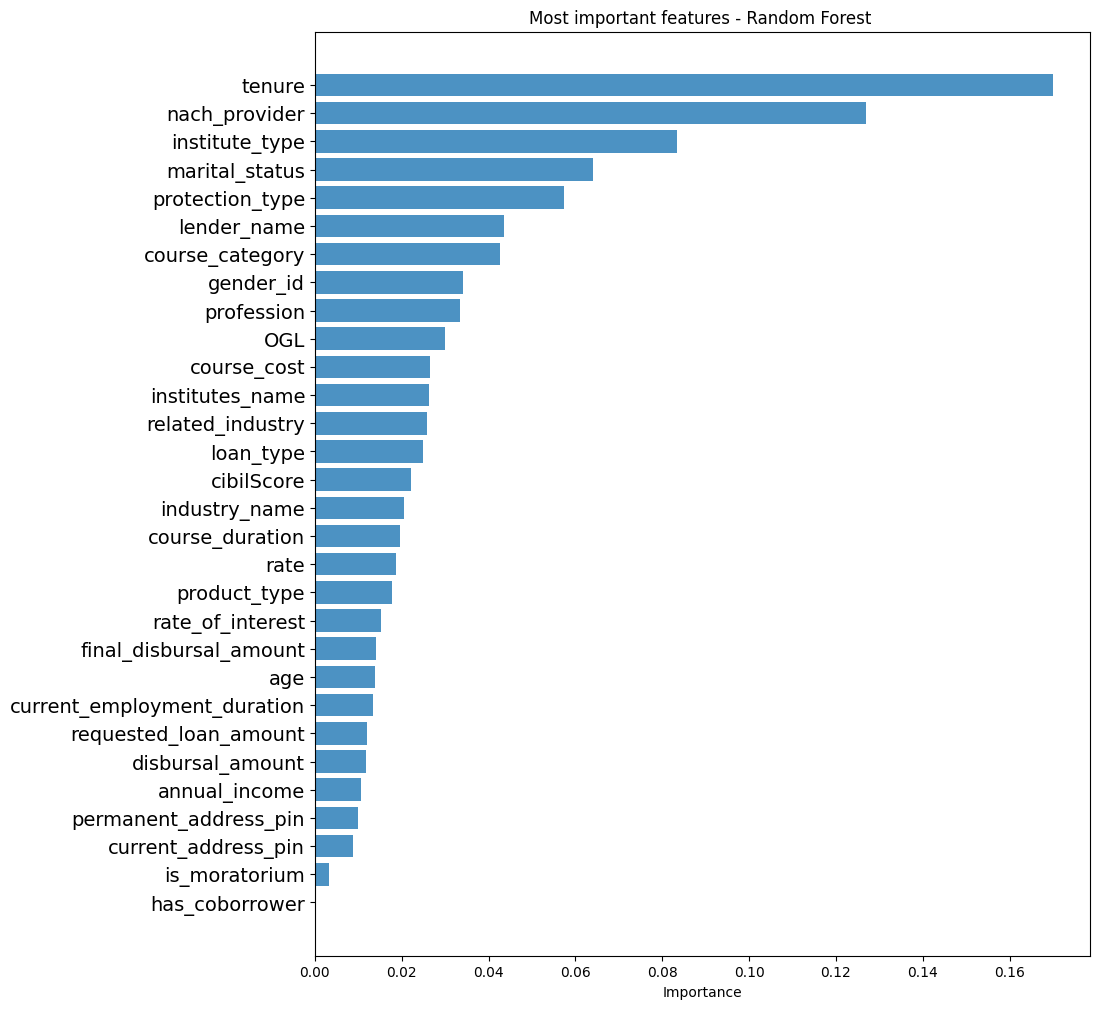

In [ ]:
feature_names = X_train.columns
feature_imports = xgb_model.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(40, "Importance")
display(most_imp_features)
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,12))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

In [ ]:
# 2 - good
# 0-bad
# 1-mod

In [ ]:
print(classification_report(y_train, xgb_pred_train))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93     36154
         1.0       0.88      0.91      0.90     36154
         2.0       0.92      0.91      0.92     36154

    accuracy                           0.91    108462
   macro avg       0.92      0.91      0.92    108462
weighted avg       0.92      0.91      0.92    108462



In [ ]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88     12083
         1.0       0.78      0.80      0.79     12068
         2.0       0.86      0.86      0.86     12004

    accuracy                           0.84     36155
   macro avg       0.84      0.84      0.84     36155
weighted avg       0.84      0.84      0.84     36155



In [ ]:
print(classification_report(y_val, xgb_pred_val))

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     12020
         1.0       0.79      0.81      0.80     12035
         2.0       0.86      0.86      0.86     12099

    accuracy                           0.85     36154
   macro avg       0.85      0.85      0.85     36154
weighted avg       0.85      0.85      0.85     36154



In [ ]:
#########################################

In [ ]:
# # def quarterly_performance_calculation
# ten = 36
# quarter_ten = ten/4
# quarter_ten = int(round(quarter_ten,1))
# input_list = [i for i in range(0,ten+1,quarter_ten)]
# quarter_list = [[input_list[i], input_list[i + 1]] for i in range(len(input_list) - 1)]

# ind_df_app_id['quarterly_performance'] = 'Bad'

# for i in quarter_list :
#   st = i[0]
#   en = i[1]
#   each_q = ind_df_app_id[(ind_df_app_id['emi_no'] > st)&(ind_df_app_id['emi_no'] <= en)]['dpd'].mean()

#   if each_q < 30 :
#     ind_df_app_id.loc[(ind_df_app_id['emi_no'] > st)&(ind_df_app_id['emi_no'] <= en)&(ind_df_app_id['status'] == 1),'quarterly_performance'] = 'Good'
#   elif ((each_q >= 30) & (each_q < 90)) :
#     ind_df_app_id.loc[(ind_df_app_id['emi_no'] > st)&(ind_df_app_id['emi_no'] <= en)&(ind_df_app_id['status'] == 1),'quarterly_performance'] = 'Medium'
#   # else:
#   #   ind_df_app_id.loc[(ind_df_app_id['emi_no'] > st)&(ind_df_app_id['emi_no'] <= en),'quarterly_performance'] = 'Bad'

# display(ind_df_app_id)

In [ ]:
3/12

0.25